In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing, metrics

import featuretools as ft
import featuretools.variable_types as vtypes
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier


In [2]:
# pickle ファイルから読み込み
train_pkl = pd.read_pickle('../001/train.pk1')

In [3]:
train_pkl.shape

(850, 11)

In [4]:
# 年齢(Age)、性別(Gender_Male)は削除
train_pkl.drop(['Gender_Male'], axis=1, inplace=True)

In [5]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,0


In [6]:
train_pk2 = train_pkl.copy()
train_pkl.shape

(850, 10)

In [7]:
es = ft.EntitySet(id='feature')

In [8]:
es.entity_from_dataframe( 
    entity_id='feature_id',
    dataframe=train_pkl.drop('disease', axis=1),
    index='index',
    variable_types={}
)

C:\Users\owner\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:609: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: feature
  Entities:
    feature_id [Rows: 850, Columns: 10]
  Relationships:
    No relationships

In [9]:
feature_matrix, features_dfs = ft.dfs(
    entityset=es,
    target_entity='feature_id',
    agg_primitives=['sum', 'mean', 'std', 'max', 'count', 'skew'],
    trans_primitives=['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric'],
    max_depth=1,
)

C:\Users\owner\Anaconda3\lib\site-packages\featuretools\synthesis\dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'max', 'mean', 'skew', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [10]:
feature_matrix.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AG_ratio + ALP,...,Age - T_Bil,Alb - ALP,Alb - ALT_GPT,Alb - AST_GOT,Alb - D_Bil,Alb - TP,Alb - T_Bil,D_Bil - TP,D_Bil - T_Bil,T_Bil - TP
index,,,,,,,,,,,,,,,,,,,,,
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,221.185532,...,58.212891,-217.067368,-10.356289,-18.617918,2.960938,-3.705078,2.324219,-6.664062,-0.636719,-6.031250
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,221.969879,...,67.996094,-218.167633,-47.982681,-61.701538,2.855469,-3.839844,2.046875,-6.695312,-0.808105,-5.886719
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,321.545441,...,64.342773,-318.282257,-10.136730,-28.124899,2.406250,-3.460938,1.831055,-5.867188,-0.576172,-5.292969
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,370.266449,...,64.093262,-365.664886,-30.734318,-50.896805,3.398438,-3.355469,2.707031,-6.753906,-0.692383,-6.062500
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,223.808395,...,20.264648,-219.713669,-17.504532,-166.941818,2.871094,-2.767578,1.333008,-5.636719,-1.537109,-4.101562


In [11]:
train_pkl = feature_matrix.copy()

In [12]:
train_pkl['disease'] = train_pk2['disease']

In [13]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AG_ratio + ALP,...,Alb - ALP,Alb - ALT_GPT,Alb - AST_GOT,Alb - D_Bil,Alb - TP,Alb - T_Bil,D_Bil - TP,D_Bil - T_Bil,T_Bil - TP,disease
index,,,,,,,,,,,,,,,,,,,,,
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,221.185532,...,-217.067368,-10.356289,-18.617918,2.960938,-3.705078,2.324219,-6.664062,-0.636719,-6.031250,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,221.969879,...,-218.167633,-47.982681,-61.701538,2.855469,-3.839844,2.046875,-6.695312,-0.808105,-5.886719,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,321.545441,...,-318.282257,-10.136730,-28.124899,2.406250,-3.460938,1.831055,-5.867188,-0.576172,-5.292969,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,370.266449,...,-365.664886,-30.734318,-50.896805,3.398438,-3.355469,2.707031,-6.753906,-0.692383,-6.062500,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,223.808395,...,-219.713669,-17.504532,-166.941818,2.871094,-2.767578,1.333008,-5.636719,-1.537109,-4.101562,0


## 訓練データとテストデータに分割

In [14]:
# 訓練とテストデータに分割
train, test = train_test_split(train_pkl, test_size=0.2, random_state=4242)

In [15]:
# ターゲットと特徴量の分割
train_X = train.iloc[:, :-1]
train_y = train.disease

In [16]:
# ターゲットと特徴量の分割
test_x = test.iloc[:, :-1]
test_y = test.disease

## 訓練データで訓練

In [ ]:
XGB = XGBClassifier(lambda_l1=0, lamba_l2=1, max_depth=7, romdam_stat=4242)
# XGB = XGBClassifier(random_state=4242)

In [ ]:
XGB = XGB.fit(train_X, train_y, early_stopping_rounds=20, eval_metric='auc', eval_set=[(test_x, test_y)])

In [ ]:
XGB.feature_importances_

In [ ]:
sorted(
    zip(map(lambda x: round(x, 3), XGB.feature_importances_), train_X.iloc[:, :].columns),
    reverse=True)

In [ ]:
train_X.shape, train_y.shape

In [ ]:
type(train_X), type(train_y)

## Boruta

In [17]:
RF = RandomForestClassifier(max_depth=7, random_state=4242)

In [18]:
feat_sel = BorutaPy(RF, n_estimators='auto', two_step=False, verbose=2, random_state=4242)

In [19]:
feat_sel.fit(train_X.values, train_y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	189
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	54
Tentative: 	68
Rejected: 	67
Iteration: 	13 / 100
Confirmed: 	54
Tentative: 	68
Rejected: 	67
Iteration: 	14 / 100
Confirmed: 	54
Tentative: 	68
Rejected: 	67
Iteration: 	15 / 100
Confirmed: 	54
Tentative: 	68
Rejected: 	67
Iteration: 	16 / 100
Confirmed: 	56
Tentative

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=7, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=184, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x206FFA85150,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='au

In [20]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 745 to 494
Columns: 189 entries, Age to T_Bil - TP
dtypes: float16(55), float32(133), int16(1)
memory usage: 433.0 KB


## 予測に使う特徴量

In [21]:
feat_sel.support_

array([False,  True, False, False, False,  True, False, False, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False,  True, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False,  True,  True, False, False, False, False,  True,
        True, False, False, False,  True, False, False, False, False,
        True,  True, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True,

In [22]:
train_X.columns[feat_sel.support_]

Index(['T_Bil', 'AST_GOT', 'AG_ratio + ALT_GPT', 'AG_ratio + AST_GOT',
       'AG_ratio + T_Bil', 'ALP + ALT_GPT', 'ALP + AST_GOT', 'ALP + D_Bil',
       'ALP + T_Bil', 'ALT_GPT + AST_GOT', 'ALT_GPT + D_Bil',
       'ALT_GPT + T_Bil', 'AST_GOT + D_Bil', 'AST_GOT + TP', 'AST_GOT + T_Bil',
       'Alb + AST_GOT', 'D_Bil + T_Bil', 'AG_ratio / ALT_GPT',
       'AG_ratio / AST_GOT', 'AG_ratio / D_Bil', 'AG_ratio / T_Bil',
       'ALT_GPT / AG_ratio', 'ALT_GPT / Alb', 'ALT_GPT / TP',
       'AST_GOT / AG_ratio', 'AST_GOT / Alb', 'Alb / ALT_GPT', 'Alb / AST_GOT',
       'Alb / D_Bil', 'Alb / T_Bil', 'D_Bil / AG_ratio', 'D_Bil / Alb',
       'D_Bil / TP', 'TP / ALT_GPT', 'TP / T_Bil', 'T_Bil / AG_ratio',
       'T_Bil / Alb', 'T_Bil / TP', 'ALP * ALT_GPT', 'ALP * AST_GOT',
       'ALP * D_Bil', 'ALP * T_Bil', 'ALT_GPT * AST_GOT', 'ALT_GPT * D_Bil',
       'ALT_GPT * T_Bil', 'AST_GOT * D_Bil', 'AST_GOT * TP', 'AST_GOT * T_Bil',
       'Alb * T_Bil', 'D_Bil * T_Bil', 'T_Bil * TP', 'AG_ratio - AL

In [23]:
len(train_X.columns[feat_sel.support_])

60

## 不要な特徴量

In [24]:
train_X.columns[~feat_sel.support_]

Index(['Age', 'D_Bil', 'ALP', 'ALT_GPT', 'TP', 'Alb', 'AG_ratio',
       'AG_ratio + ALP', 'AG_ratio + Age', 'AG_ratio + Alb',
       ...
       'Age - Alb', 'Age - D_Bil', 'Age - TP', 'Age - T_Bil', 'Alb - ALP',
       'Alb - D_Bil', 'Alb - TP', 'Alb - T_Bil', 'D_Bil - TP', 'T_Bil - TP'],
      dtype='object', length=129)

In [25]:
len(train_X.columns[~feat_sel.support_])

129

## 必要な特徴量で再実行

In [84]:
train_X_sel = train_X.iloc[:, feat_sel.support_]

In [85]:
XGB3 = XGBClassifier(lambda_l1=0, lamba_l2=1, max_depth=7, romdam_stat=4242)
# XGB = XGBClassifier(random_state=4242)

In [87]:
XGB3 = XGB3.fit(train_X_sel, train_y, early_stopping_rounds=20, eval_metric='auc', eval_set=[(test_X_sel, test_y)])

[0]	validation_0-auc:0.907561
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.906453
[2]	validation_0-auc:0.92231
[3]	validation_0-auc:0.921064
[4]	validation_0-auc:0.919886
[5]	validation_0-auc:0.918709
[6]	validation_0-auc:0.920787
[7]	validation_0-auc:0.924318
[8]	validation_0-auc:0.924179
[9]	validation_0-auc:0.926395
[10]	validation_0-auc:0.93145
[11]	validation_0-auc:0.93415
[12]	validation_0-auc:0.936089
[13]	validation_0-auc:0.938028
[14]	validation_0-auc:0.940936
[15]	validation_0-auc:0.941906
[16]	validation_0-auc:0.94336
[17]	validation_0-auc:0.942944
[18]	validation_0-auc:0.943775
[19]	validation_0-auc:0.94426
[20]	validation_0-auc:0.944121
[21]	validation_0-auc:0.94973
[22]	validation_0-auc:0.950976
[23]	validation_0-auc:0.950561
[24]	validation_0-auc:0.951392
[25]	validation_0-auc:0.950422
[26]	validation_0-auc:0.949868
[27]	validation_0-auc:0.950145
[28]	validation_0-auc:0.9525
[29]	validation_0-auc:0.9525
[30]	validation_0-auc:0.95

Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x000002068316FCF8>>
Traceback (most recent call last):
  File "C:\Users\owner\Anaconda3\lib\site-packages\xgboost\core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


In [88]:
sorted(
    zip(map(lambda x: round(x, 3), XGB.feature_importances_), train_X_sel.iloc[:, :].columns),
    reverse=True)

[(0.019, 'T_Bil'),
 (0.014, 'T_Bil / AG_ratio'),
 (0.014, 'T_Bil * TP'),
 (0.013, 'Alb / AST_GOT'),
 (0.011, 'AST_GOT + D_Bil'),
 (0.01, 'D_Bil * T_Bil'),
 (0.01, 'ALT_GPT * D_Bil'),
 (0.01, 'ALP + AST_GOT'),
 (0.008, 'T_Bil / TP'),
 (0.008, 'AG_ratio / D_Bil'),
 (0.007, 'Alb + AST_GOT'),
 (0.007, 'AST_GOT + T_Bil'),
 (0.007, 'AST_GOT * TP'),
 (0.007, 'ALP * AST_GOT'),
 (0.007, 'AG_ratio / AST_GOT'),
 (0.006, 'D_Bil + T_Bil'),
 (0.006, 'AST_GOT * D_Bil'),
 (0.006, 'ALT_GPT / Alb'),
 (0.006, 'ALT_GPT + T_Bil'),
 (0.006, 'AG_ratio - ALT_GPT'),
 (0.005, 'D_Bil - T_Bil'),
 (0.005, 'Alb / D_Bil'),
 (0.005, 'Alb * T_Bil'),
 (0.005, 'AST_GOT * T_Bil'),
 (0.005, 'AST_GOT'),
 (0.005, 'ALT_GPT / AG_ratio'),
 (0.005, 'ALT_GPT * AST_GOT'),
 (0.005, 'ALP + T_Bil'),
 (0.005, 'ALP + D_Bil'),
 (0.005, 'ALP + ALT_GPT'),
 (0.005, 'AG_ratio / ALT_GPT'),
 (0.005, 'AG_ratio - AST_GOT'),
 (0.005, 'AG_ratio + ALT_GPT'),
 (0.004, 'D_Bil / Alb'),
 (0.004, 'Alb / T_Bil'),
 (0.004, 'Alb - AST_GOT'),
 (0.004, 'Al

## テストデータで実行

In [89]:
test_x.shape, test_y.shape

((170, 189), (170,))

In [90]:
test_X_sel = test_x.iloc[:, feat_sel.support_]

In [91]:
test_X_sel.shape

(170, 60)

In [92]:
pred_y = XGB3.predict(test_X_sel)

In [93]:
confusion_matrix(test_y, pred_y)

array([[79,  8],
       [12, 71]], dtype=int64)

In [94]:
accuracy_score(test_y, pred_y)

0.8823529411764706

In [95]:
test_y.sum(), pred_y.sum()

(83, 79)

## ROC曲線

In [113]:
roc_auc_score(test_y, pred_y)

0.881733831879241

In [114]:
fpr, tpr, thr = roc_curve(test_y, pred_y)

In [115]:
auc = metrics.auc(fpr, tpr)

In [116]:
auc

0.881733831879241

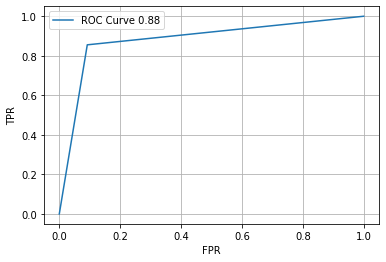

In [117]:
plt.plot(fpr, tpr, label="ROC Curve %.2f"%auc)
plt.legend()
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.grid()
plt.show()

## 学習曲線

In [108]:
XGB2 = XGBClassifier(lambda_l1=0, lamba_l2=1, max_depth=7, romdam_stat=4242)

In [109]:
train_X.shape, test_x.shape

((680, 189), (170, 189))

In [110]:
train_size, train_scores, test_scores = \
learning_curve(estimator=XGB2, X=train_X_sel, y=train_y, 
               train_sizes=np.linspace(0.1, 1.0, 10))

In [111]:
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

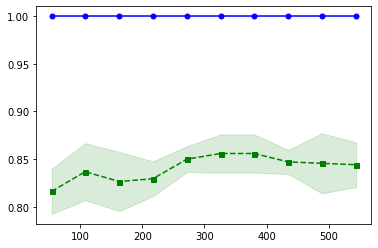

In [112]:
plt.plot(train_size, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.plot(train_size, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_size, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.fill_between(train_size, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')


## 検証データで実行

In [37]:
# 検証データ読み込み
valid = pd.read_pickle('../001/test.pk1')

In [38]:
valid.shape

(350, 10)

In [39]:
type(valid)

pandas.core.frame.DataFrame

In [40]:
# valid_X = valid.iloc[:, 1:]
valid_X = valid.copy()

In [41]:
valid_X.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Male
0,25,0.801758,0.186768,214.448685,15.260516,19.496649,6.816406,3.601562,1.288086,1
1,26,0.834961,0.116455,234.136810,10.509159,16.733311,6.796875,3.111328,1.030273,0
2,64,0.791992,0.197998,216.039902,14.578304,20.695866,7.523438,3.626953,1.278320,1
3,65,0.833984,0.175781,200.901123,12.820356,20.102516,6.828125,3.626953,1.275391,1
4,34,0.690430,0.135498,208.705841,20.279018,25.096685,8.664062,4.171875,1.280273,0


In [42]:
# 年齢、性別は削除
valid_X.drop(['Gender_Male'], axis=1, inplace=True)

In [43]:
valid_X.shape

(350, 9)

In [44]:
es2 = ft.EntitySet(id='feature2')

In [45]:
es2.entity_from_dataframe( 
    entity_id='feature_id2',
    dataframe=valid_X,
    index='index',
    variable_types={}
)

C:\Users\owner\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:609: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: feature2
  Entities:
    feature_id2 [Rows: 350, Columns: 10]
  Relationships:
    No relationships

In [46]:
feature_matrix, features_dfs = ft.dfs(
    entityset=es2,
    target_entity='feature_id2',
    agg_primitives=['sum', 'mean', 'std', 'max', 'count', 'skew'],
    trans_primitives=['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric'],
    max_depth=1,
)

C:\Users\owner\Anaconda3\lib\site-packages\featuretools\synthesis\dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'max', 'mean', 'skew', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [47]:
feature_matrix.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AG_ratio + ALP,...,Age - T_Bil,Alb - ALP,Alb - ALT_GPT,Alb - AST_GOT,Alb - D_Bil,Alb - TP,Alb - T_Bil,D_Bil - TP,D_Bil - T_Bil,T_Bil - TP
index,,,,,,,,,,,,,,,,,,,,,
0,25,0.801758,0.186768,214.448685,15.260516,19.496649,6.816406,3.601562,1.288086,215.736771,...,24.198242,-210.847122,-11.658954,-15.895086,3.414062,-3.214844,2.800781,-6.628906,-0.615234,-6.015625
1,26,0.834961,0.116455,234.136810,10.509159,16.733311,6.796875,3.111328,1.030273,235.167084,...,25.165039,-231.025482,-7.397831,-13.621983,2.994141,-3.685547,2.277344,-6.679688,-0.718750,-5.960938
2,64,0.791992,0.197998,216.039902,14.578304,20.695866,7.523438,3.626953,1.278320,217.318222,...,63.208008,-212.412949,-10.951351,-17.068913,3.429688,-3.896484,2.835938,-7.324219,-0.593750,-6.730469
3,65,0.833984,0.175781,200.901123,12.820356,20.102516,6.828125,3.626953,1.275391,202.176514,...,64.166016,-197.274170,-9.193403,-16.475563,3.451172,-3.201172,2.792969,-6.652344,-0.658203,-5.992188
4,34,0.690430,0.135498,208.705841,20.279018,25.096685,8.664062,4.171875,1.280273,209.986115,...,33.309570,-204.533966,-16.107143,-20.924810,4.035156,-4.492188,3.480469,-8.531250,-0.554688,-7.972656


In [67]:
valid_X = feature_matrix.copy().iloc[:, feat_sel.support_]

In [68]:
# valid_X = valid_X.iloc[:, feat_sel.support_]

In [74]:
valid_X.shape, train_X_sel.shape

((350, 60), (680, 60))

In [75]:
train_X_sel.head()

,T_Bil,AST_GOT,AG_ratio + ALT_GPT,AG_ratio + AST_GOT,AG_ratio + T_Bil,ALP + ALT_GPT,ALP + AST_GOT,ALP + D_Bil,ALP + T_Bil,ALT_GPT + AST_GOT,...,T_Bil * TP,AG_ratio - ALT_GPT,AG_ratio - AST_GOT,AG_ratio - D_Bil,AG_ratio - T_Bil,ALT_GPT - TP,AST_GOT - TP,Alb - ALT_GPT,Alb - AST_GOT,D_Bil - T_Bil
index,,,,,,,,,,,,,,,,,,,,,
745,0.733887,18.399479,11.461545,19.725651,2.060547,226.970398,235.234497,216.950562,217.568909,28.534851,...,4.347656,-8.809201,-17.073307,1.210938,0.592285,4.209592,12.473698,-6.527951,-14.792057,-0.618164
526,0.822754,147.058319,56.436951,147.818085,1.582031,401.445435,492.826569,345.913269,346.591003,202.735504,...,5.730469,-54.917419,-146.298553,0.614746,-0.062988,48.712341,140.093475,-52.589294,-143.970428,-0.677734
828,0.721191,49.835690,20.205805,51.105221,1.990234,383.664276,414.563690,364.955536,365.449188,68.771965,...,5.445312,-17.666742,-48.566158,1.041992,0.548340,11.385492,42.284908,-15.297602,-46.197018,-0.493652
803,0.797852,23.183985,21.133356,24.965235,2.578125,244.347717,248.179596,225.156738,225.793457,42.536091,...,6.058594,-17.570856,-21.402735,1.620117,0.983398,11.758356,15.590235,-15.004450,-18.836329,-0.636719
767,0.762695,19.241785,15.143185,20.545496,2.066406,227.419891,232.822205,213.790619,214.343109,33.081261,...,5.750000,-12.535763,-17.938074,1.093750,0.541016,6.300411,11.702723,-9.585567,-14.987879,-0.552734


In [70]:
valid_X.head()

,T_Bil,AST_GOT,AG_ratio + ALT_GPT,AG_ratio + AST_GOT,AG_ratio + T_Bil,ALP + ALT_GPT,ALP + AST_GOT,ALP + D_Bil,ALP + T_Bil,ALT_GPT + AST_GOT,...,T_Bil * TP,AG_ratio - ALT_GPT,AG_ratio - AST_GOT,AG_ratio - D_Bil,AG_ratio - T_Bil,ALT_GPT - TP,AST_GOT - TP,Alb - ALT_GPT,Alb - AST_GOT,D_Bil - T_Bil
index,,,,,,,,,,,,,,,,,,,,,
0,0.801758,19.496649,16.548603,20.784735,2.089844,229.709198,233.945328,214.635452,215.250443,34.757164,...,5.464844,-13.972430,-18.208563,1.101562,0.486328,8.444110,12.680243,-11.658954,-15.895086,-0.615234
1,0.834961,16.733311,11.539433,17.763584,1.865234,244.645966,250.870117,234.253265,234.971771,27.242470,...,5.675781,-9.478886,-15.703037,0.914062,0.195312,3.712284,9.936436,-7.397831,-13.621983,-0.718750
2,0.791992,20.695866,15.856625,21.974186,2.070312,230.618210,236.735764,216.237900,216.831894,35.274170,...,5.957031,-13.299984,-19.417545,1.080078,0.486328,7.054867,13.172428,-10.951351,-17.068913,-0.593750
3,0.833984,20.102516,14.095747,21.377907,2.109375,213.721481,221.003632,201.076904,201.735107,32.922874,...,5.695312,-11.544966,-18.827126,1.099609,0.441406,5.992231,13.274391,-9.193403,-16.475563,-0.658203
4,0.690430,25.096685,21.559292,26.376959,1.970703,228.984863,233.802521,208.841339,209.396271,45.375702,...,5.980469,-18.998745,-23.816412,1.144531,0.589844,11.614956,16.432623,-16.107143,-20.924810,-0.554688


In [73]:
valid_X.columns

Index(['T_Bil', 'AST_GOT', 'AG_ratio + ALT_GPT', 'AG_ratio + AST_GOT',
       'AG_ratio + T_Bil', 'ALP + ALT_GPT', 'ALP + AST_GOT', 'ALP + D_Bil',
       'ALP + T_Bil', 'ALT_GPT + AST_GOT', 'ALT_GPT + D_Bil',
       'ALT_GPT + T_Bil', 'AST_GOT + D_Bil', 'AST_GOT + TP', 'AST_GOT + T_Bil',
       'Alb + AST_GOT', 'D_Bil + T_Bil', 'AG_ratio / ALT_GPT',
       'AG_ratio / AST_GOT', 'AG_ratio / D_Bil', 'AG_ratio / T_Bil',
       'ALT_GPT / AG_ratio', 'ALT_GPT / Alb', 'ALT_GPT / TP',
       'AST_GOT / AG_ratio', 'AST_GOT / Alb', 'Alb / ALT_GPT', 'Alb / AST_GOT',
       'Alb / D_Bil', 'Alb / T_Bil', 'D_Bil / AG_ratio', 'D_Bil / Alb',
       'D_Bil / TP', 'TP / ALT_GPT', 'TP / T_Bil', 'T_Bil / AG_ratio',
       'T_Bil / Alb', 'T_Bil / TP', 'ALP * ALT_GPT', 'ALP * AST_GOT',
       'ALP * D_Bil', 'ALP * T_Bil', 'ALT_GPT * AST_GOT', 'ALT_GPT * D_Bil',
       'ALT_GPT * T_Bil', 'AST_GOT * D_Bil', 'AST_GOT * TP', 'AST_GOT * T_Bil',
       'Alb * T_Bil', 'D_Bil * T_Bil', 'T_Bil * TP', 'AG_ratio - AL

In [102]:
pred_valid_y = XGB3.predict(valid_X)

In [103]:
pred_valid_y.shape

(350,)

In [104]:
# type(valid_pass), type(pred_valid_y)

In [105]:
result_df = pd.DataFrame(pred_valid_y)

In [106]:
result_df.to_csv("./XGB_10.csv", header=False)

In [107]:
pred_valid_y.sum()

146